# Model Explainability - Feature Importance  

This file contains codes that explain about the model's prediction work by analyzing and ranking importance of the best selected features and their influence on the model's prediction output

## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold  # a CV with folds where each one contains the same ratio of classes as in general dataset
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict  # for generating confusion matrix with CV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import shap
import warnings

warnings.filterwarnings("ignore")

file = 'C:/Users/tomna/OneDrive/Datasets/Model 1 Rework/Dataset - Phase 2/Combined/Dataset_Final.csv'
df = pd.read_csv(file)

## Data Cleaning

In [2]:
# replacing Null, Void and Unknown values observed with NaN
df.replace(['Null','Void','Unknown'],np.nan,inplace=True)

# replacing -1 and -8 with NaN
df.replace([-1.0,-1,-8],np.nan,inplace=True)

# dropping all columns with at least 50% missing values
df_null_cols = round((df.isnull().sum()/df.shape[0]*100), 1).sort_values(ascending=True) 
df_null_cols_del = df_null_cols[df_null_cols > 50.0]
cols_del = df_null_cols_del.index.to_list()   # return a list of columns to be deleted
df.drop(cols_del,axis = 1,inplace = True)  

# imputing the missing values
    # first, we identify numerical and categorical columns
numeric_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
    # imputing numeric columns
imputer = SimpleImputer(strategy='median',missing_values=np.nan)
imputer = imputer.fit(df[numeric_cols])
df[numeric_cols] = imputer.transform(df[numeric_cols])
    # imputing categorical columns
imputer = SimpleImputer(strategy='constant',missing_values=np.nan,fill_value='Unknown')
imputer = imputer.fit(df[categorical_cols])
df[categorical_cols] = imputer.transform(df[categorical_cols])

# removing duplicated records
df.drop_duplicates(keep='first',inplace=True)

# identifying and removing irrelevant columns
cols = df.columns.to_list()
    # get fractions (%) of unique values for each column sorted by the largest
    # if the fraction is 1, this means the column has only one unique value thus irrelevant for prediction
for col in cols :
    counts_unique_values = round(df[col].value_counts(sort=True, normalize=True),3)  
    if counts_unique_values.iloc[0] == 1.0 :
        df.drop([col],axis = 1,inplace=True)  # drop column with one unique value only

## Feature Encoding

Since all our categorical columns have nominal values (values are not in order), we convert categorical columns into numeric values using label encoding. We use this method in order to analyze the importance of each individual features in this prediction task. This analysis would be difficult for one hot encoded data

In [3]:
# label encoding the categorical columns
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
for col in categorical_cols :
    df[col] = LabelEncoder().fit_transform(df[col])

## Feature Dependencies
Investigating correlations among the columns

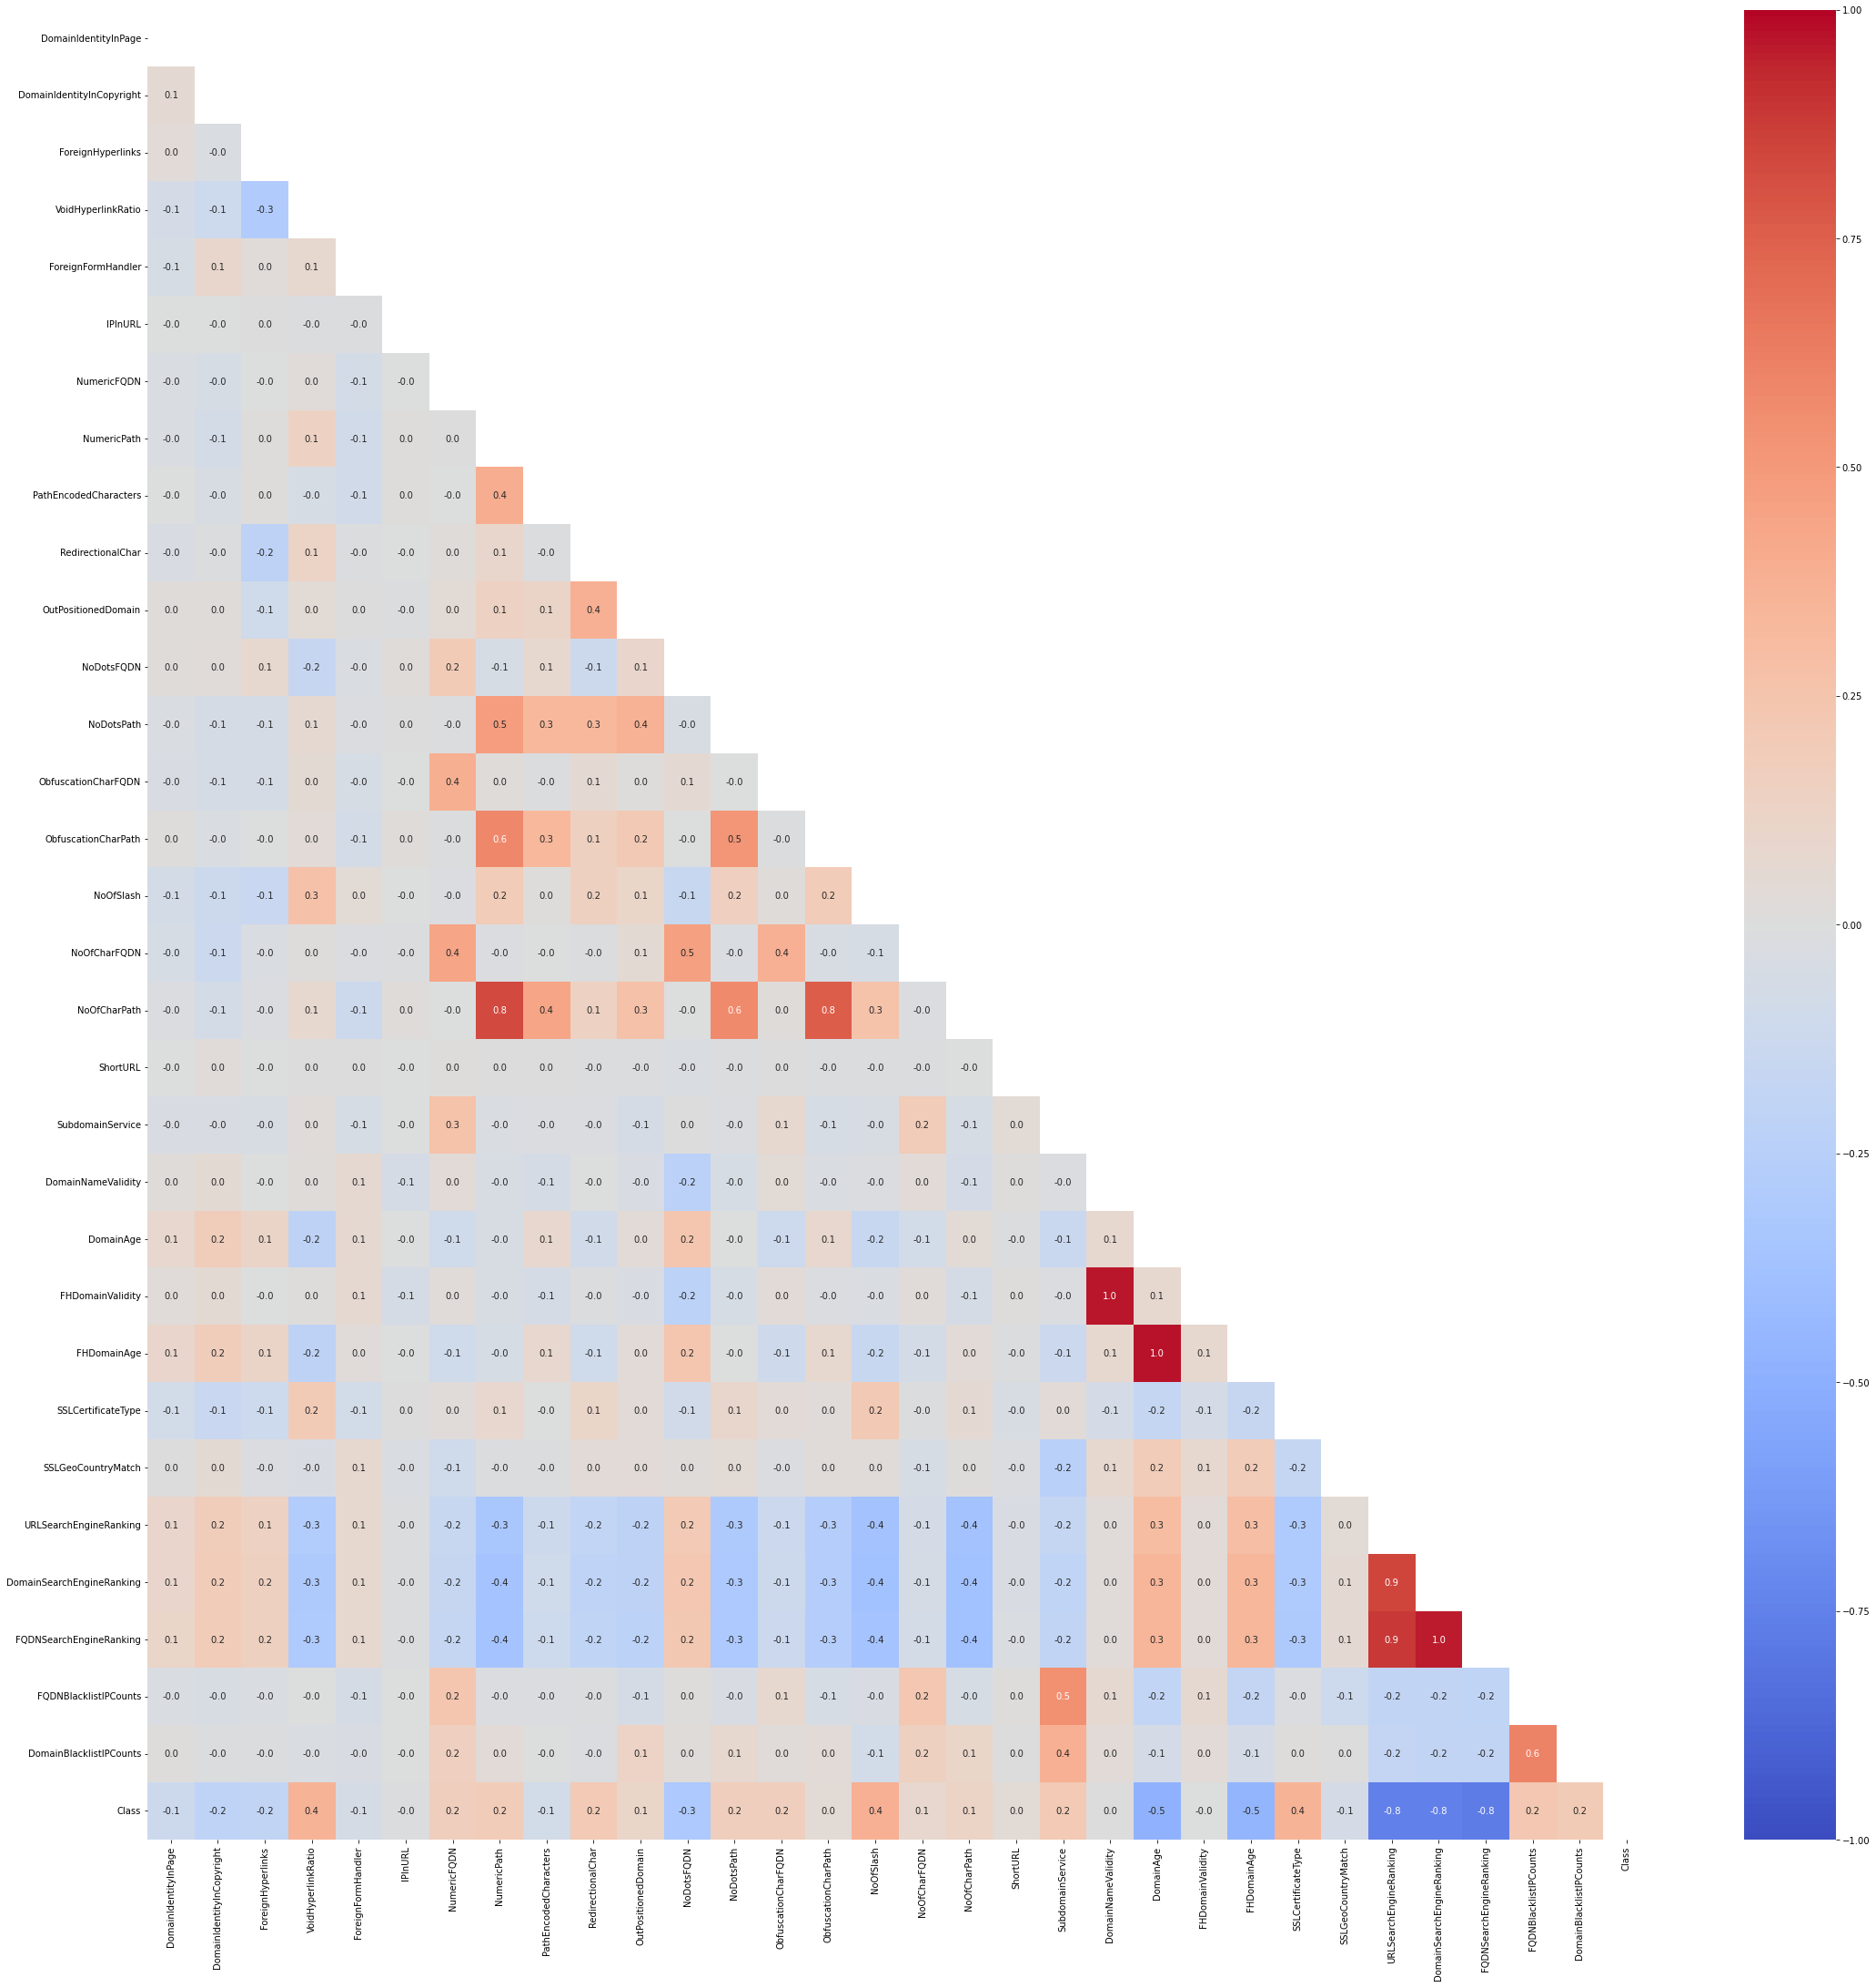

In [4]:
plt.figure(figsize=(37,37))
corr_matrix = df.corr()
mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
image = sns.heatmap(corr_matrix, annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask) # annot=show numbers, fmt='.1f'= show 1 number of decimal places

Columns FHDomainAge, FHDomainValidity, FQDNSearchEngineRanking and DomainSearchEngineRanking are observed to have correlation coefficients of 0.9 or more with other columns, therefore they are dropped

In [5]:
df.drop(['FHDomainAge','FHDomainValidity','DomainSearchEngineRanking','FQDNSearchEngineRanking'],axis=1,inplace=True)

## Splitting  Prediction and Target Variables
We split the dataset into prediction features and a target

In [6]:
df = shuffle(df)
X = df.drop(["Class"],axis=1)
y = df["Class"]
print('Number of Features before selection: ', len(X.columns.to_list()))

Number of Features before selection:  27


## Feature Selection
Recursive Feature Elimination (RFE) is used to automatically identify the best predictive features

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
kf = StratifiedKFold(n_splits=10,random_state=2,shuffle=True)
rfecv = RFECV(estimator=RandomForestClassifier(), min_features_to_select=3, cv=kf, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])
for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
df_features.sort_values(by='ranking')
df_features = df_features[df_features['support']==True]  # selected best features always give support value as True
best_features = df_features['feature'].tolist()  # get all values of the column
print("Number of features after feature selection : ", len(df_features['feature']))
X = df[best_features]

Number of features after feature selection :  23


## Model Evaluation
We evaluate again the dataset with categorical columns label encoded using the same set of ML algorithms in order to compare their results with the dataset in which the categorical columns were one hot encoded

In [8]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=4)))
models.append(('LGBM', LGBMClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state=20)))
models.append(('XGB', XGBClassifier()))
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
for name,model in models:
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    accurs = []
    precs = []
    recs = []
    f1s = []
    FPRs = []
    FNRs = []
    aucs = []
    for train_index, test_index in rkf.split(X, y):
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = model.score(X_test_scaled, y_test)
        accurs.append(accuracy)
        precision = precision_score(y_test, y_pred)
        precs.append(precision)
        recall = recall_score(y_test, y_pred)
        recs.append(recall)
        f1 = f1_score(y_test, y_pred)
        f1s.append(f1)
        if name == 'SVM' :
            auc = roc_auc_score(y_test, model.decision_function(X_test_scaled))
        else: 
            auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        aucs.append(auc)
        cm = confusion_matrix(y_test, y_pred)
        TN = TN + cm[0,0]
        TP = TP + cm[1,1]
        FN = FN + cm[1,0]
        FP = FP + cm[0,1]
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    accur_mean = round((np.mean(accurs)*100),2)
    prec_mean = round(np.mean(precs),2)
    recall_mean = round(np.mean(recs),2)
    f1_mean = round(np.mean(f1s),2)
    AUC_mean = round(np.mean(aucs),2)
    print(name, ' -- Accuracy :', round((np.mean(accurs)*100),2),'%', ' | FPR :', round(FPR*100,2),' | FNR :', round(FNR*100,2), ' | Precision :', prec_mean,' | Recall :', recall_mean,' | F1 :', f1_mean,' | AUC :', AUC_mean )

LR  -- Accuracy : 93.7 %  | FPR : 5.21  | FNR : 7.51  | Precision : 0.94  | Recall : 0.92  | F1 : 0.93  | AUC : 0.98
KNN  -- Accuracy : 95.43 %  | FPR : 3.73  | FNR : 5.5  | Precision : 0.96  | Recall : 0.94  | F1 : 0.95  | AUC : 0.98
DT  -- Accuracy : 97.22 %  | FPR : 2.77  | FNR : 2.78  | Precision : 0.97  | Recall : 0.97  | F1 : 0.97  | AUC : 0.97
NB  -- Accuracy : 84.5 %  | FPR : 3.41  | FNR : 28.97  | Precision : 0.95  | Recall : 0.71  | F1 : 0.81  | AUC : 0.96
SVM  -- Accuracy : 96.01 %  | FPR : 2.89  | FNR : 5.21  | Precision : 0.97  | Recall : 0.95  | F1 : 0.96  | AUC : 0.99
NN  -- Accuracy : 96.93 %  | FPR : 2.41  | FNR : 3.8  | Precision : 0.97  | Recall : 0.96  | F1 : 0.97  | AUC : 0.99
RF  -- Accuracy : 98.42 %  | FPR : 1.14  | FNR : 2.06  | Precision : 0.99  | Recall : 0.98  | F1 : 0.98  | AUC : 1.0
LGBM  -- Accuracy : 98.43 %  | FPR : 1.19  | FNR : 1.99  | Precision : 0.99  | Recall : 0.98  | F1 : 0.98  | AUC : 1.0
GB  -- Accuracy : 97.81 %  | FPR : 1.58  | FNR : 2.88  | 

The above results indicate that XBG is still outperforming other algorithms when label encoding categorical data. However, this result is slightly lower than the one obtained by one hot encoding the data, concluding that the latter method is better for this dataset

## Feature Importance
Here we analyze how each feature influences the model's prediction output and therefore helps us to understand their importance levels in the task. We analyze this using SHAP values computed by a SHAP package using the best performing algorithm XGB

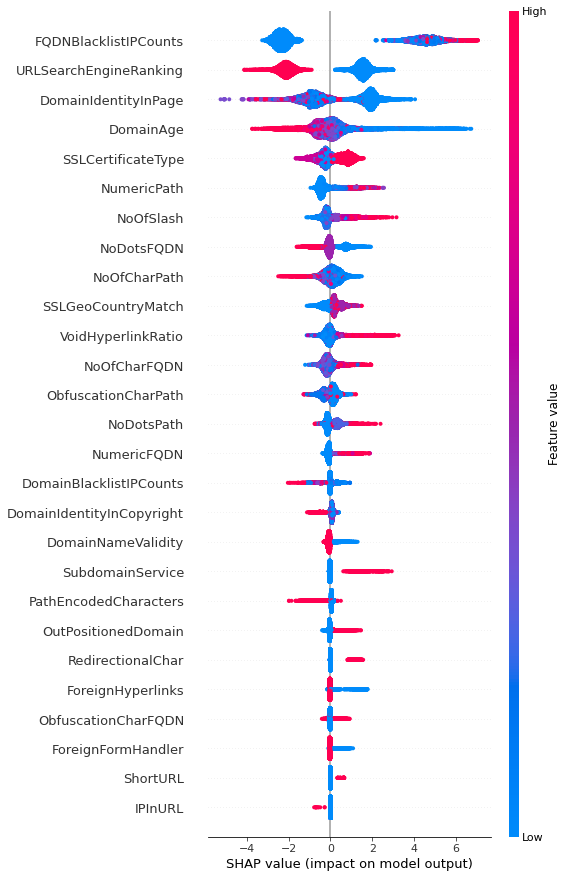

In [13]:
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=len(X_train), color=plt.get_cmap("tab20c"))

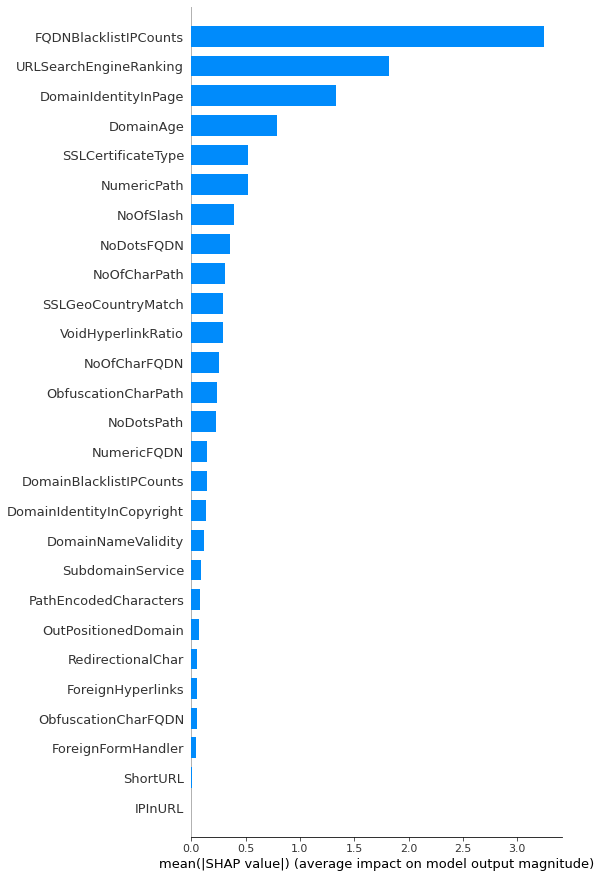

In [12]:
shap.summary_plot(shap_values, X_train, max_display=len(X_train), show=False, plot_type='bar')

The first plot shows the SHAP value of each feature on each data sample. This explains how the low (blue) and high (red) values of each feature positively or negatively affect the model output with respect to each sample. The plot ranks the features based on their influence on the model output with respect to individual samples. The top feature FQDNBlacklistIPCounts is most influential feature whereas IPInURL is the least one. The next figure similarly ranks the overall importance of the features for prediction based on their mean SHAP values across all samples